This notebook is part of the $\omega radlib$  documentation: http://wradlib.org/wradlib-docs.

Copyright (c) 2016, $\omega radlib$  developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Match spaceborn PR (GPM/TRMM) with ground radars

The idea is to match ground radar (GR) and space-born radar (PR) measurements in order to create spatially and temporally coicident samples without interpolation. The procedure had been suggested [Schwaller and Morris (2011)](http://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHA1403.1), and is based on IDL code provided by Rob Warren (Monash University, Australia). 

The basic principle is illustrated in Fig. 2 of the original paper of Schwaller and Morris (2011):

![image](fig2_schwaller_morris_2011.PNG)


*Quote: "[...] The matchup method averages PR and GR full-resolution space and ground radar bins within the min-
imum volume needed to produce a spatially coincident sample. The along-ray PR data are averaged 
only in the vertical, between the top and bottom height of each GR elevation sweep it intersects [...] 
The GR data are averaged only in the horizontal within the individual elevation sweep surfaces, over an 
approximately circular area centered on each intersecting PR ray’s parallax-adjusted profile [...]".*

This becomes clearer in Fig. 3:
![image](fig3_schwaller_morris_2011.PNG)

Schwaller, MR, and Morris, KR. 2011. A ground validation network for the Global Precipitation Measurement mission. J. Atmos. Oceanic Technol., 28, 301-319.

### Conventions

This code is based on the following conventions:

- `gr` indicates **g**round **r**adar
- `pr` indicates space-born **p**recipitation **r**adar (TRMM or GPM)

The base routines are designed to process one GR sweep at a time. If a full GR volume with `nelev` of sweeps is available, you can iterate over each sweep. In this code, `ee` is an index that points to one of the `nelev` sweep/elevation angle. Accordingly, a **GR** data set will be organised as an array of shape `(nray_gr, ngate_gr)`

A **PR** data set is typically organised as arrays with dimesions `(nscan_pr, nray_pr, ngate_pr)`.

In [23]:
import wradlib as wradlib
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt
from osgeo import osr

In [24]:
# Import from external libraries
#    these functions and objects will finally have to be moved to wradlib!
from external import *
from io_func import *

In [25]:
# Set parameters for this procedure
bw_pr = 0.71                  # PR beam width
platf = "gpm"                 # PR platform/product: one out of ["gpm", "trmm_2a23", "trmm_2a25"]
zt = pr_pars[platf]["zt"]     # PR orbit height (meters)
dr_pr = pr_pars[platf]["dr"]  # PR gate length (meters)
ee = 2                        # Index that points to the GR elevation angle to be used

In [26]:
# define GPM data set
gpm_file = wradlib.util.get_wradlib_data_file('gpm/2A-RW-BRS.GPM.Ku.V6-20160118.20141206-S095002-E095137.004383.V04A.HDF5')

# define matching ground radar file
gr2gpm_file = wradlib.util.get_wradlib_data_file('hdf5/IDR66_20141206_094829.vol.h5')

# define TRMM data sets
trmm_2a23_file = wradlib.util.get_wradlib_data_file('trmm/2A-RW-BRS.TRMM.PR.2A23.20100206-S111422-E111519.069662.7.HDF')
trmm_2a25_file = wradlib.util.get_wradlib_data_file('trmm/2A-RW-BRS.TRMM.PR.2A25.20100206-S111422-E111519.069662.7.HDF')

# define matching ground radar file
gr2trmm_file = wradlib.util.get_wradlib_data_file('hdf5/IDR66_20100206_111233.vol.h5')

#### Read and organize the data

In [27]:
# read spaceborn PR data
if platf == "gpm":
    pr_data = read_gpm(gpm_file)
elif platf == "trmm2a23":
    pr_data = io_func.read_trmm(trmm_2a23_file)
elif platf == "trmma25":
    pr_data = io_func.read_trmm(trmm_2a25_file)
else:
    raise("Invalid platform")
# read matching GR data
if platf == "gpm":
    gr_data = read_gr(gr2gpm_file)
elif "trmm" in platf:
    gr_data = wradlib.io.read_generic_hdf5(gr2trmm_file)
else:
    raise("Invalid platform")

#### Extract relevant GR data and meta-data

In [28]:
# number of rays in gr sweep
nray_gr = gr_data['nbeam'].astype("i4")[ee]
# number of gates in gr beam
ngate_gr = gr_data['ngate'].astype("i4")[ee]
# number of sweeps
nelev = gr_data['ntilt']
# elevation of sweep (degree)
elev = gr_data['elang'][ee]
# gate length (meters)
dr_gr = gr_data['dr'][ee]
# reflectivity array of sweep
ref_gr = gr_data['refl'][ee]
# sweep datetime stamp
date_gr = gr_data['sdate'][ee]
# range of first gate
r0_gr = gr_data['r0'][ee]                    
# azimuth angle of first beam
a0_gr = gr_data['a0'][ee]
# Longitude of GR
lon0_gr = gr_data['lon']
# Latitude of GR
lat0_gr = gr_data['lat']
# Altitude of GR (meters)
alt0_gr = gr_data['alt']
# Beam width of GR (degree)
bw_gr = 1.

#### Extract relevant PR data and meta-data

In [29]:
# Longitudes of PR scans
pr_lon = pr_data['lon']
# Latitudes of PR scans
pr_lat = pr_data['lat']
# Precip flag
pflag = pr_data['pflag']
# Number of scans on PR data
nscan_pr= pr_data['nscan']
# Number of rays in one PR scan
nray_pr = pr_data['nray']
# Number of gates in one PR ray
ngate_pr = pr_data['nbin']

#### Set fundamental georeferencing parameters

In [30]:
# Calculate equivalent earth radius
wgs84 = wradlib.georef.get_default_projection()
re1 = wradlib.georef.get_earth_radius(lat0_gr, wgs84) * 4./3.
print("eff. Earth radius 1:", re1)
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
print("SemiMajor, SemiMinor:", a, b)

# Set up aeqd-projection gr-centered
rad = wradlib.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' + 
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0_gr,
                                                      lat=lat0_gr,
                                                      a=a, b=b))
re2 = wradlib.georef.get_earth_radius(lat0_gr, rad) * 4./3.
print("eff. Earth radius 2:", re2)

('eff. Earth radius 1:', 8498054.7197525594)
('SemiMajor, SemiMinor:', 6378137.0, 6356752.314245179)
('eff. Earth radius 2:', 8498054.7197525073)


#### Georeference GR data

In [31]:
# TODO: Seperate the insides of wradlib.georef.polar2lonlatalt_n 

# create gr range and azimuth arrays
rmax_gr = r0_gr + ngate_gr * dr_gr
r_gr = np.arange(0, ngate_gr) * dr_gr + dr_gr/2.
az_gr = np.arange(0, nray_gr) - a0_gr
print("Range/Azi-Shape:", r_gr.shape, az_gr.shape)

# create gr lonlat grid
gr_polargrid = np.meshgrid(r_gr, az_gr)
gr_lon, gr_lat, gr_alt = wradlib.georef.polar2lonlatalt_n(gr_polargrid[0], gr_polargrid[1], elev, (lon0_gr, lat0_gr, alt0_gr ))
gr_ll = np.dstack((gr_lon, gr_lat, gr_alt))
print("LonLatAlt-Grid-Shape", gr_ll.shape)

# reproject to xyz
gr_xyz = wradlib.georef.reproject(gr_ll, projection_source=wgs84, projection_target=rad)
print("XYZ-Grid-Shape:", gr_xyz.shape)

# get radar domain (outer ring)
gr_domain = gr_xyz[:,-1,0:2]
gr_domain = np.vstack((gr_domain, gr_domain[0]))
print("Domain-Shape:", gr_domain.shape)

('Range/Azi-Shape:', (600L,), (360L,))
('LonLatAlt-Grid-Shape', (360L, 600L, 3L))
('XYZ-Grid-Shape:', (360L, 600L, 3L))
('Domain-Shape:', (361L, 2L))


#### Georeference PR data

In [32]:
pr_x, pr_y = wradlib.georef.reproject(pr_lon, pr_lat, 
                                      projection_source=wgs84, 
                                      projection_target=rad)
pr_xy = np.dstack((pr_x, pr_y))
print("PR-GRID-Shapes:", pr_x.shape, pr_y.shape, pr_xy.shape)

('PR-GRID-Shapes:', (137L, 49L), (137L, 49L), (137L, 49L, 2L))


In [99]:
pr_xy.shape

(137L, 49L, 2L)

#### Subset relevant PR data

In [33]:
# Create ZonalData for spatial subsetting (inside GR range domain)
l_gr = []
l_gr.append(gr_domain)
zd = wradlib.zonalstats.ZonalDataPoint(pr_xy.reshape(-1, pr_xy.shape[-1]), l_gr, srs=rad, buf=500.)
obj1 = wradlib.zonalstats.GridPointsToPoly(zd)

#    Get source indices within GR-Domain from zonal object
#    (0 because we have only one zone)
pr_idx = obj1.zdata.get_source_index(0) 

# Subsetting in order to use only precipitating profiles
src_idx = np.zeros_like(pflag, dtype=np.bool)
mask = np.unravel_index(pr_idx, pflag.shape)
src_idx[mask] = True

# get precip indexes
precip_mask = (pflag == 2)
precip_idx = src_idx & precip_mask

# get iscan/iray boolean arrays
iscan = precip_idx.nonzero()[0]
iray = precip_idx.nonzero()[1]

Calculate Intersection source/target-layers


#### PR Parallax Correction

In [34]:
print("NRAY", nray_pr)
print("NBIN", ngate_pr)

# Approximation!
alpha = abs(-17.04 + np.arange(nray_pr) * bw_pr)

# Correct for parallax, get 3D-XYZ-Array
#   xyzp_pr: Parallax corrected xyz coordinates
#   r_pr_inv: range array from ground to PR platform
#   zp: PR bin altitudes
xyzp_pr, r_pr_inv, z_pr = correct_parallax(pr_xy, nray_pr, ngate_pr, dr_pr, alpha)

print("PR_XYP:", xyzp_pr.shape, z_pr.shape)

('NRAY', 49L)
('NBIN', 176L)
('PRANGE:', (176L,), 21875.0)
('HEIGHT:', (49L, 176L), 21875.0)
('XDIFF:', (137L, 49L))
('Ang:', (137L, 49L))
('DX:', (137L, 49L, 176L))
('XP:', (137L, 49L, 176L))
('PR_XYP:', (137L, 49L, 176L, 3L), (49L, 176L))


#### Compute spherical coordinates of PR bins with regard to GR

In [35]:
# TODO: Do we have to consider refraction in sat2pol?
r_pr, elev_pr, az_pr = sat2pol(xyzp_pr, (lon0_gr, lat0_gr, alt0_gr), re1)    
mask = (elev_pr > (1.0 - bw_gr/2.)) & (elev_pr < (1.0 + bw_gr/2.))
##pl.figure()
##pl.pcolormesh(mask[90,:,:].T)

#### Compute PR and GR pulse volumes

In [36]:
# PR pulse volumes

# Range of PR bins
dists = dist_from_orbit(zt, alpha, r_pr_inv)

## Original IDL code...
##    rt=zt/COS(!dtor*alpha)-range
##    volp=(1.e-9)*!pi*(rt*!dtor*bwt/2.)^2*drt
## Translated to Python
vol_pr2  = np.pi * dr_pr * (dists * np.radians(bw_pr / 2.))**2
##fig = pl.figure(figsize=(12,4))
##pm = pl.pcolor(vol_pr.T)
##pl.colorbar(pm)

# Or using wradlib's native function
vol_pr = wradlib.qual.pulse_volume(dists, dr_pr, bw_pr)
#vol_pr = np.pi * dr_pr * (dists ** 2) * (np.tan(np.radians(bw_pr/2.))) ** 2

# Evaluate difference between both approaches
print("Min. difference (m3):", (vol_pr - vol_pr2).min())
print("Max. difference (m3): ", (vol_pr - vol_pr2).max())
print("Average rel. difference (%):", round(np.mean(vol_pr-vol_pr2)*100./np.mean(np.mean(vol_pr2)), 4))

# Verdict: differences are negligble - use wradlibs's native function!

('Min. difference (m3):', 57227.448025226593)
('Max. difference (m3): ', 69916.997128486633)
('Average rel. difference (%):', 0.0026)


In [37]:
# GR pulse volumes
#   along one beam
vol_gr = wradlib.qual.pulse_volume(r_gr, dr_gr, bw_gr)
#   with shape (nray_gr, ngate_gr)
vol_gr = np.repeat(vol_gr, nray_gr).reshape((nray_gr,ngate_gr), order="F")

#### Median Brightband Width/Height

In [38]:
ratio, zbb = get_bb_ratio(pr_data, z_pr)
##pl.pcolormesh(ratio[60,:,:].T, vmin=-1, vmax=2)
##pl.colorbar()

('ZBB', (137L, 49L), -1111.1, 4814.7271)
('BBWidth', (137L, 49L), -1111.1, 1340.8645)
('MEDIAN:', 3855.8948, 747.69403)
('ZMLT:', (137L, 49L))
('RATIO:', (137L, 49L, 176L))


#### Convert PR Ku reflectivities to S-band 

Based on Cao et.al (2013)

In [39]:
# REVERSE!!!
refp = pr_data['refl'][:,:,::-1]
print("REFP:", refp.shape)

refp_ss = np.zeros_like(refp) * np.nan
refp_sh = np.zeros_like(refp) * np.nan

a_s, a_h = s_ku_coefficients()

ia = (ratio >= 1)
refp_ss[ia] = refp[ia] + calculate_polynomial(refp[ia], a_s[:,10])
refp_sh[ia] = refp[ia] + calculate_polynomial(refp[ia], a_h[:,10])
ib = (ratio <= 0)
refp_ss[ib] = refp[ib] + calculate_polynomial(refp[ib], a_s[:,0])
refp_sh[ib] = refp[ib] + calculate_polynomial(refp[ib], a_h[:,0])
im = (ratio > 0) & (ratio < 1)
ind = np.round(ratio[im] * 10).astype(np.int)
#print("W:", a_s[:,ind].shape)
refp_ss[im] = refp[im] + calculate_polynomial(refp[im], a_s[:,ind])
refp_sh[im] = refp[im] + calculate_polynomial(refp[im], a_h[:,ind])

refp_ss[refp < 0] = np.nan
out = np.ma.masked_invalid(refp_ss)
##pl.figure()
##pl.pcolormesh(out[60,:,:].T, vmin=0, vmax=60)
##pl.colorbar()
##pl.figure()
##pl.pcolormesh(refp[60,:,:].T, vmin=0, vmax=60)
##pl.colorbar()
##pl.figure()
##pl.pcolormesh(ratio[60,:,:].T, vmin=-1, vmax=2)
##pl.colorbar()

('REFP:', (137L, 49L, 176L))


#### Convert S-band GR reflectivities to Ku-band

Using the method of Liao and Meneghini (2009)

In [40]:
# Convert S-band GR reflectivities to Ku-band using method of Liao and Meneghini (2009)
ref_gr_ku = np.zeros_like(ref_gr) * np.nan

# Which zbb value should we take here???
#    Q'n'Dirty: just take the mean of all PR profiles
#    TODO: Consider zbb for each profile during the matching process

# Snow
ia = ( gr_xyz[...,2] >= np.nanmean(zbb) )
ref_gr_ku[ia] = ku2s["snow"][0] + ku2s["snow"][1]*ref_gr[ia] + ku2s["snow"][2]*ref_gr[ia]**2

# Rain
ib = ( gr_xyz[...,2] < np.nanmean(zbb) )
ref_gr_ku[ib] = ku2s["rain"][0] + ku2s["rain"][1]*ref_gr[ib] + ku2s["rain"][2]*ref_gr[ib]**2

# Jackson Tan's fix for C-band
is_cband = False
if (is_cband):
    delta = (ref_gr_ku - ref_gr) * 5.3/10.0
    ref_gr_ku = ref_gr + delta

#### Identify which PR rays actually intersect with the GR sweep

Based on the above criteria (in radar range, precipitating PR profile) and based on PR elevation angle (with regard to GR).

In [41]:
# First assumption: no valid PR bins (all False)
valid = np.asarray(elev_pr, dtype=np.bool)==False
# PR is inside GR range and is precipitating
valid[iscan,iray] = True
# PR bins intersect with GR sweep
valid = valid & (elev_pr >= elev-bw_gr/2.) & (elev_pr <= elev+bw_gr/2.)
# Number of matching PR bins per profile
nvalids = np.sum(valid, axis=2)
# scan and ray indices for profiles with at least one valid bin
vscan, vray = np.where(nvalids>0)
# number of profiles with at least one valid bin
nprof = len(vscan)

In [42]:
# Lots of containers to store samples (only for one GR sweep angle!)
x = np.zeros(nprof)*np.nan        # x coordinate of sample
y = np.zeros(nprof)*np.nan        # y coordinate of sample
z = np.zeros(nprof)*np.nan        # z coordinate of sample
dz = np.zeros(nprof)*np.nan       # depth of sample
ds = np.zeros(nprof)*np.nan       # width of sample
rs = np.zeros(nprof)*np.nan       # range of sample from GR
refpr1 = np.zeros(nprof)*np.nan     # PR reflectivity
refpr2 = np.zeros(nprof)*np.nan     # PR reflectivity (S-band, snow)
refpr3 = np.zeros(nprof)*np.nan     # PR reflectivity (S-band, hail)  
refgr1 = np.zeros(nprof)*np.nan     # GR reflectivity
refgr2 = np.zeros(nprof)*np.nan     # GR reflectivity (Ku-band)
ntotpr = np.zeros(nprof,dtype="i4")# total number of PR bins in sample
nrej1 = np.zeros(nprof,dtype="i4")# number of rejected PR bins in sample
ntotgr = np.zeros(nprof,dtype="i4")# total number of GR bins in sample
nrej2 = np.zeros(nprof,dtype="i4")# number of rejected GR bins in sample
iref1 = np.zeros(nprof)*np.nan    # path-integrated PR reflectivity
iref2 = np.zeros(nprof)*np.nan    # path-integrated GR reflectivity
stdv1 = np.zeros(nprof)*np.nan    # std. dev. of PR reflectivity in sample
stdv2 = np.zeros(nprof)*np.nan    # std. dev. of GR reflectivity in sample
volpr = np.zeros(nprof)*np.nan     # total volume of PR bins in sample
volgr = np.zeros(nprof)*np.nan     # total volume of GR bins in sample

In [154]:
# Loop over relevant PR profiles
for ii, (ss, rr)  in enumerate(zip(vscan,vray)):
    # Index and count valid bins in each profile
    ip = np.where(valid[ss,rr])[0]
    numbins = len(ip)
    ntotpr[ii]=numbins
    if numbins == 0:
        continue
    # Compute the mean position of these bins
    x[ii]=np.mean(xyzp_pr[ss,rr,ip,0])
    y[ii]=np.mean(xyzp_pr[ss,rr,ip,1])
    z[ii]=np.mean(xyzp_pr[ss,rr,ip,2])

    # Thickness of the layer
    dz[ii]=(numbins * dr_pr) * np.cos( np.radians(alpha[rr]) )

    # PR averaging volume
    volpr[ii]=np.sum(vol_pr2[rr,ip])

    # Note mean TRMM beam diameter
    ds[ii]=np.radians(bw_pr) * np.mean( ( (zt-z[ii]) / np.cos( np.radians(alpha[rr]) ) ) )

    # Note distance from radar
    s=np.sqrt(x[ii]**2+y[ii]**2)
    rs[ii]=(re2+z[ii]) * np.sin(s/re2) / np.cos(np.radians(elev))
    
    # This should not be required because we applied ZonalData
    ### Check that sample is within radar range
    ##if r[ii,jj]+ds[ii,jj]/2. gt rmax then continue

    ## THIS IS THE ORIGINAL IDL CODE - IS THIS A BUG???
    ##ref1[ii,jj]=MEAN(refp1,/nan)
    ##ref3[ii,jj]=MEAN(refp2,/nan)
    ##ref4[ii,jj]=MEAN(refp3,/nan)
    
    # Simple linear average of reflectivity 
    #   - we can become fancier in the next step
    # ATTENTION: NEED TO FLIP ARRAY
    refpr1[ii]=np.nanmean(np.flipud(refp)   [ss,rr,ip])
    refpr2[ii]=np.nanmean(np.flipud(refp_ss)[ss,rr,ip])
    refpr3[ii]=np.nanmean(np.flipud(refp_sh)[ss,rr,ip])
    
    ## Not sure why we need this...
    ### Note the number of rejected bins
    ##nrej1[ii,jj]=ROUND(TOTAL(FINITE(refp1,/nan)))
    ##if FINITE(stdv1[ii,jj]) eq 0 and np-nrej1[ii,jj] gt 1 then STOP

    # SHOULD WE USE ZONALDATA INSTEAD? COULD BE MORE ACCURATE, BUT ALSO SLOWER
    # WE COULD BASICALLY START A NEW LOOP HERE AND RUN ZONALDATA BEFORE
    
    # Compute the horizontal distance to all the GR bins
    d = np.sqrt((gr_xyz[...,0]-x[ii])**2 + (gr_xyz[...,1]-y[ii])**2)

    # Find all GR bins within the SR beam
    aa, bb = np.where(d <= ds[ii]/2.)

    # Store the number of bins
    ntotgr[ii] = len(aa)

    if len(aa) == 0:
        continue

    # Extract the relevant GR bins

    # Compute the GR averaging volume
    volgr[ii]=np.sum(vol_gr[aa,bb])

    # Average over those bins that exceed the reflectivity threshold 
    #   IDL code does exponential distance and volume weighting
    #   Let's try simple mean first,
    #   THEN ZonalStats!
    refgr1[ii]=np.nanmean(ref_gr[aa,bb])
    refgr2[ii]=np.nanmean(ref_gr_ku[aa,bb])

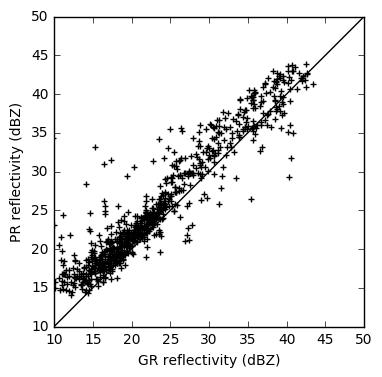

In [153]:
ax = pl.scatter(refgr1, refpr1, marker="+", c="black")
ax.axes.set_aspect("equal")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(10,50)
pl.ylim(10,50)
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("PR reflectivity (dBZ)")

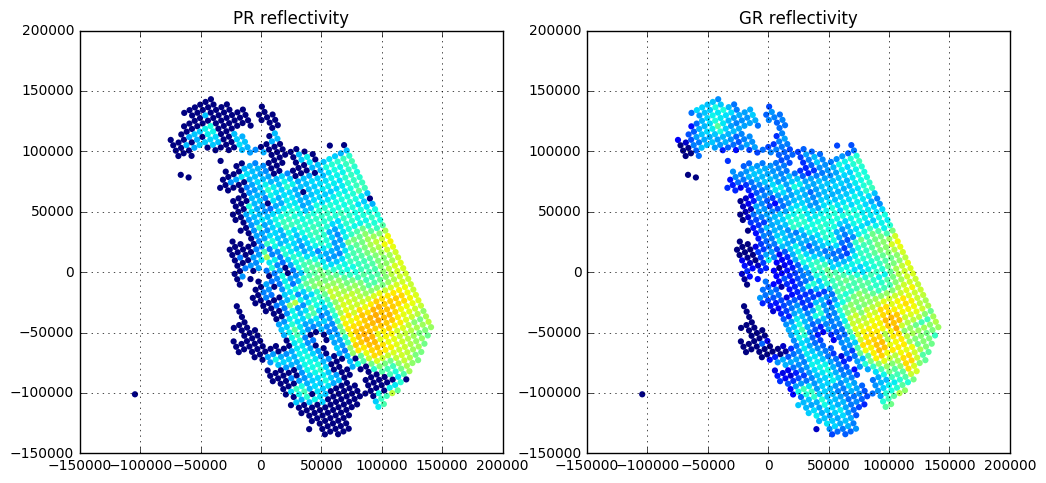

In [124]:
fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(121, aspect="equal")
pl.scatter(x, y, c=refpr1, cmap=pl.cm.jet, vmin=0, vmax=60, edgecolor="None")
pl.title("PR reflectivity")
pl.grid()
ax = fig.add_subplot(122, aspect="equal")
pl.scatter(x, y, c=refgr1, cmap=pl.cm.jet, vmin=0, vmax=60, edgecolor="None")
pl.title("GR reflectivity")
pl.grid()